In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
# Load and inspect data
data = pd.read_csv('/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv',sep=';',index_col='id')
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [12]:
# Check for for missing data and incorrect data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [13]:
# One-hot encode gender column
data['gender_f'] = (data.gender==1).astype(int)
data['gender_m'] = (data.gender==2).astype(int)

In [14]:
data.drop(columns=['gender'],inplace=True)
data = data[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc',
             'smoke', 'alco', 'active', 'gender_f', 'gender_m', 'cardio']]

In [15]:
# Confirm changes
data.head()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_f,gender_m,cardio
id,,,,,,,,,,,,,
0,18393,168,62.0,110,80,1,1,0,0,1,0,1,0
1,20228,156,85.0,140,90,3,1,0,0,1,1,0,1
2,18857,165,64.0,130,70,3,1,0,0,0,1,0,1
3,17623,169,82.0,150,100,1,1,0,0,1,0,1,1
4,17474,156,56.0,100,60,1,1,0,0,0,1,0,0


In [16]:
# Check data summary
data.iloc[:,:5].describe().T[['mean','std','min','max']]

,mean,std,min,max
age,19468.865814,2467.251667,10798.0,23713.0
height,164.359229,8.210126,55.0,250.0
weight,74.205690,14.395757,10.0,200.0
ap_hi,128.817286,154.011419,-150.0,16020.0
ap_lo,96.630414,188.472530,-70.0,11000.0


In [17]:
# Create folder to store images
import os
if not os.path.exists('/kaggle/working/images'):
    os.makedirs('/kaggle/working/images')

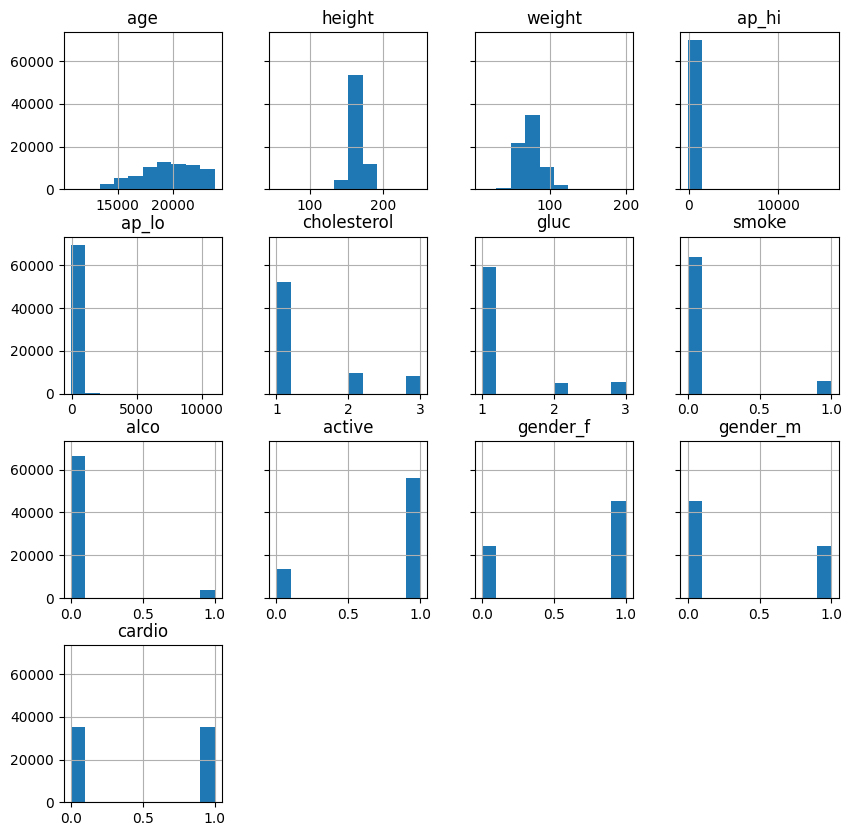

In [18]:
# Plot data distribution
import matplotlib.pyplot as plt
data.hist(figsize=(10,10),sharey=True)
plt.savefig('images/orig_data_summary.png');

In [19]:
# Split data into training, validation and test sets
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Seperate num data from cat data
num_train = data_train.iloc[:,:5]
cat_train = data_train.iloc[:,5:]
num_test = data_test.iloc[:,:5]
cat_test = data_test.iloc[:,5:]

# Normalize the data
scaler = StandardScaler()
num_train_normalized = scaler.fit_transform(num_train)
num_test_normalized = scaler.transform(num_test)

# Concatenate num and cat data
data_train_normalized = np.concatenate([num_train_normalized,cat_train],axis=1)
data_test_normalized = np.concatenate([num_test_normalized,cat_test],axis=1)

(data_train_normalized.shape,data_test_normalized.shape)

((56000, 13), (14000, 13))

# VAE

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

# VAE Parameters
input_dim = data_train.shape[1]
intermediate_dim = 50
latent_dim = 5

# Encoder
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(inputs, x_decoded_mean)

reconstruction_loss = mse(inputs, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer=Adam())
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


# Train VAE
history = vae.fit(data_train_normalized, None, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Epoch 1/100
1400/1400 [==============================] - 5s 2ms/step - loss: 138.2339 - val_loss: 7.2320
Epoch 2/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.9207 - val_loss: 7.0969
Epoch 3/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.8210 - val_loss: 7.0564
Epoch 4/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7990 - val_loss: 7.0496
Epoch 5/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7869 - val_loss: 7.0578
Epoch 6/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7884 - val_loss: 7.0471
Epoch 7/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7781 - val_loss: 7.0247
Epoch 8/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7744 - val_loss: 7.0211
Epoch 9/100
1400/1400 [==============================] - 3s 2ms/step - loss: 6.7686 - val_loss: 6.9969
Epoch 10/100
1400/1400 [==============================] - 3s 2ms/step -

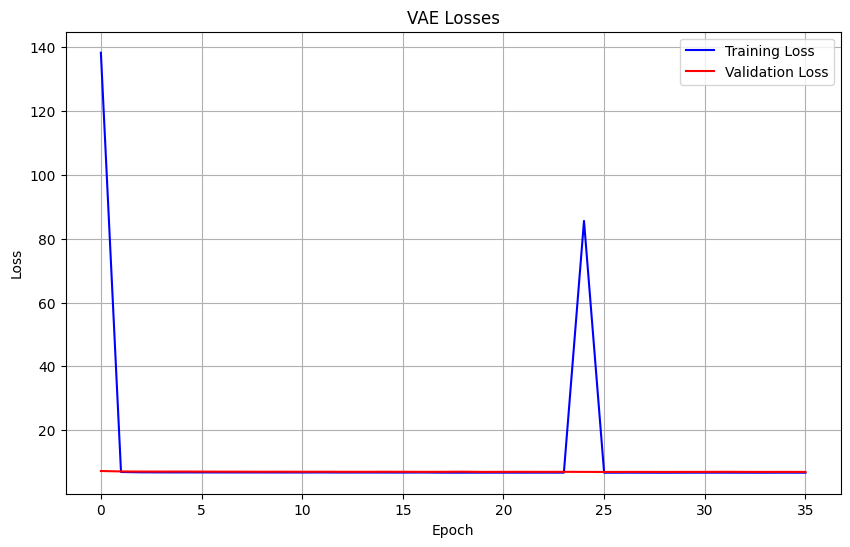

In [21]:
import matplotlib.pyplot as plt

# Extract losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plo losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('VAE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('images/vae_losses.png')
plt.show()

In [22]:
# Generate synthetic data
num_samples = 56000
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
vae_data = decoder_mean(decoder_h(random_latent_vectors))

In [23]:
# Round categorical variables to nearest integers
vae_cat_data = vae_data[:,5:].numpy().round()
vae_num_data = vae_data[:,:5].numpy()
vae_data = np.concatenate([vae_num_data,vae_cat_data],axis=1)

# Check number of invalid data points
(vae_data[:,-2]==vae_data[:,-3]).sum()

174

In [24]:
# Post-process data
vae_data_df = pd.DataFrame()
num_cols = data.columns[:5]
cat_cols = data.columns[5:]
vae_data_df[num_cols] = scaler.inverse_transform(vae_num_data)
vae_data_df[cat_cols] = vae_cat_data
weight = vae_data_df['weight']
vae_data_df = vae_data_df.round().astype(int)
vae_data_df['weight'] = weight
vae_data_df.head()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_f,gender_m,cardio
0,19465,164,74.191460,129,97,1,1,0,0,1,1,0,0
1,19638,164,74.188583,129,97,1,1,0,0,1,1,0,1
2,19466,164,74.188660,129,97,1,1,0,0,1,1,0,0
3,20360,164,74.188583,129,97,1,1,0,0,1,1,0,1
4,19465,164,74.188599,129,97,1,1,0,0,1,1,0,0


In [25]:
# Show data summary
vae_data_df[num_cols].describe().T[['mean','std','min','max']]

,mean,std,min,max
age,19854.080750,724.884429,19465.000000,21934.000000
height,165.805000,2.960222,164.000000,173.000000
weight,76.281494,4.270834,74.188583,88.549599
ap_hi,129.111036,2.311759,129.000000,268.000000
ap_lo,99.679250,16.984381,97.000000,295.000000


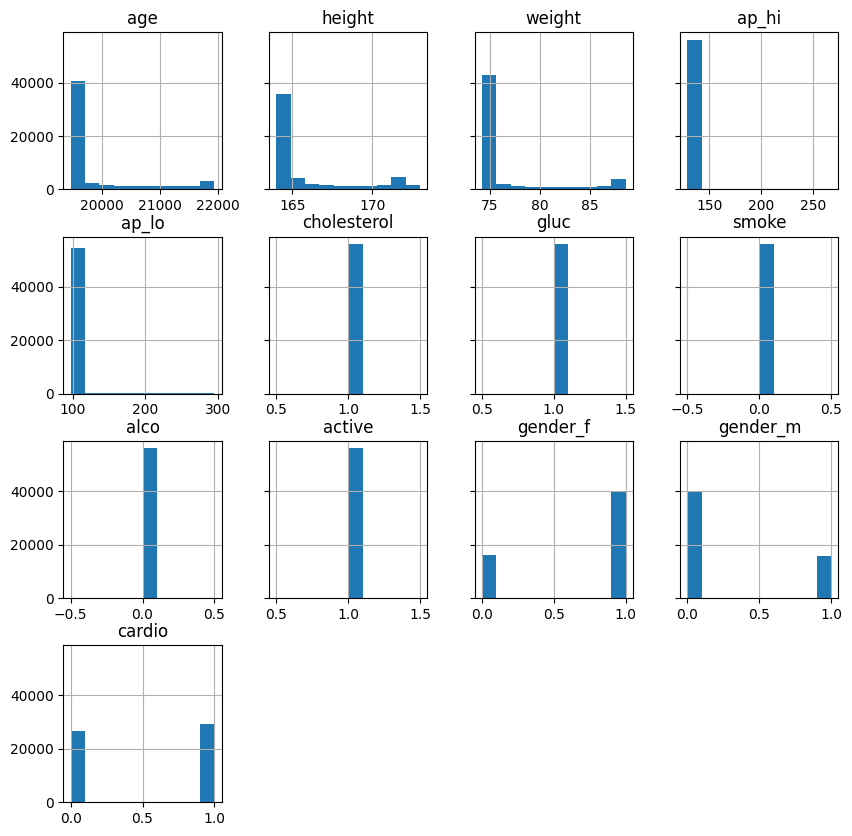

In [26]:
# Plot data distribution
vae_data_df.hist(figsize=(10,10),sharey=True)
plt.savefig('images/vae_data_summary.png');

# GAN

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# GAN Parameters
input_dim = data_train.shape[1] - 1
noise_dim = 200

# Function to add noise to labels
def add_label_noise(labels, noise_factor=0.1):
    noise = noise_factor * np.random.randn(labels.shape[0], labels.shape[1])
    return np.clip(labels + noise, 0, 1)  # Clip to keep labels between 0 and 1

# Generator
def build_generator():
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,), dtype='float32')
    model_input = Concatenate()([noise, label])
    
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(input_dim, activation='sigmoid')(x)
    
    model = Model([noise, label], x)
    return model

generator = build_generator()

# Discriminator
def build_discriminator():
    data = Input(shape=(input_dim,))
    label = Input(shape=(1,), dtype='float32')
    model_input = Concatenate()([data, label])
    
    x = Dense(128)(model_input) 
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model([data, label], x)
    return model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])

# Combined Model
z = Input(shape=(noise_dim,))
label = Input(shape=(1,), dtype='float32')
data = generator([z, label])
validity = discriminator([data, label])
combined = Model([z, label], validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

# Training GAN with Soft and Noisy Labels
epochs = 100
batch_size = 64
half_batch = batch_size // 2
losses = {'disc':[],'gen':[]}

for epoch in range(epochs):
    idx = np.random.randint(0, data_train_normalized.shape[0], half_batch)
    real_data = data_train_normalized[idx, :-1]
    real_labels = data_train_normalized[idx, -1].reshape(-1, 1)
    
    noise = np.random.normal(0, 1, (half_batch, noise_dim))
    sampled_labels = np.random.randint(0, 2, half_batch).reshape(-1, 1)
    generated_data = generator.predict([noise, sampled_labels])
    
    # Using soft and noisy labels
    d_loss_real = discriminator.train_on_batch([real_data, real_labels], add_label_noise(np.ones((half_batch, 1)) * 0.9))
    d_loss_fake = discriminator.train_on_batch([generated_data, sampled_labels], add_label_noise(np.zeros((half_batch, 1))))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch([noise, sampled_labels], valid_labels)
    
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
    losses['disc'].append(d_loss[0])
    losses['gen'].append(g_loss)


1/1 [==============================] - 0s 143ms/step
0/100 [D loss: 0.9335699379444122 | D accuracy: 17.1875] [G loss: 0.9638676643371582]
1/1 [==============================] - 0s 23ms/step
1/100 [D loss: 0.9037231504917145 | D accuracy: 17.1875] [G loss: 0.9372233748435974]
1/1 [==============================] - 0s 22ms/step
2/100 [D loss: 0.8793734014034271 | D accuracy: 9.375] [G loss: 0.9262515306472778]
1/1 [==============================] - 0s 22ms/step
3/100 [D loss: 0.8594442903995514 | D accuracy: 20.3125] [G loss: 0.8924744129180908]
1/1 [==============================] - 0s 21ms/step
4/100 [D loss: 0.854295939207077 | D accuracy: 21.875] [G loss: 0.9375768899917603]
1/1 [==============================] - 0s 22ms/step
5/100 [D loss: 0.8623998165130615 | D accuracy: 17.1875] [G loss: 0.893787145614624]
1/1 [==============================] - 0s 25ms/step
6/100 [D loss: 0.8679162263870239 | D accuracy: 17.1875] [G loss: 0.8964836001396179]
1/1 [==============================] -

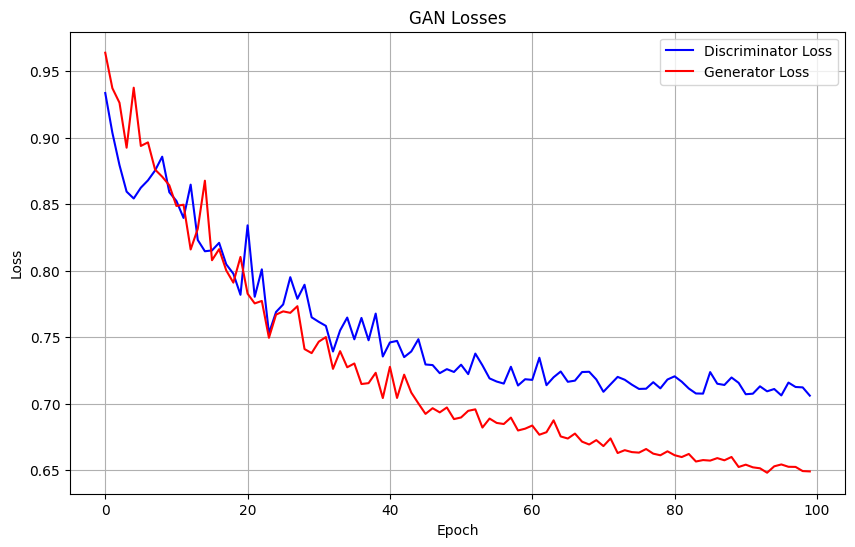

In [28]:
# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(losses['disc'], label='Discriminator Loss', color='blue')
plt.plot(losses['gen'], label='Generator Loss', color='red')
plt.title('GAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('images/gan_losses.png')
plt.show()

In [29]:
# Generate synthetic data
num_samples = 56000
noise = np.random.normal(0, 1, (num_samples, noise_dim))
sampled_labels = np.random.randint(0, 2, num_samples).reshape(-1, 1)
gan_data = generator.predict([noise, sampled_labels])
gan_data = np.concatenate([gan_data, sampled_labels], axis=1)

1750/1750 [==============================] - 3s 2ms/step


In [30]:
# Check number of invalid data points
(gan_data[:,-2]==gan_data[:,-3]).sum()

0

In [31]:
# Post-process data
gan_num_data = gan_data[:,:5]
gan_cat_data = gan_data[:,5:]
gan_data_df = pd.DataFrame()
gan_data_df[num_cols] = scaler.inverse_transform(gan_num_data)
gan_data_df[cat_cols] = gan_cat_data
weight = gan_data_df['weight']
gan_data_df = gan_data_df.round().astype(int)
gan_data_df['weight'] = weight
gan_data_df.head()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_f,gender_m,cardio
0,20287,170,81.627972,169,168,1,0,0,1,0,1,1,1
1,21638,168,78.206177,152,193,1,1,0,0,0,1,1,1
2,21242,169,78.984493,141,212,1,1,0,1,0,1,0,1
3,20350,171,78.565559,196,129,1,1,0,1,0,0,1,0
4,21170,166,77.659986,223,174,1,0,0,0,0,0,1,0


In [32]:
# Show data summary
gan_data_df[num_cols].describe().T[['mean','std','min','max']]

,mean,std,min,max
age,20922.951393,482.440630,19514.00000,21913.000000
height,168.143232,1.602045,164.00000,172.000000
weight,81.834591,3.088332,74.39413,88.417105
ap_hi,188.950661,31.993220,129.00000,274.000000
ap_lo,182.786196,45.657357,98.00000,294.000000


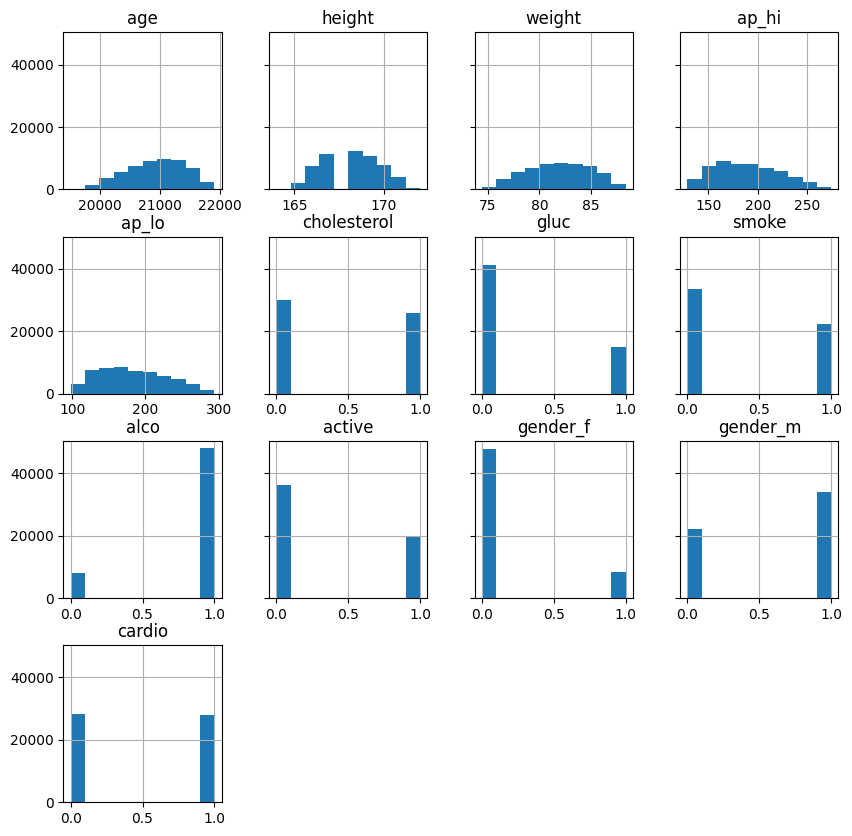

In [33]:
# Plot data summary
gan_data_df.hist(figsize=(10,10),sharey=True)
plt.savefig('images/gan_data_summary.png');

# VAE-GAN

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# VAE-GAN Parameters
input_dim = data_train.shape[1] - 1  # Assuming last column is the label
intermediate_dim = 50
latent_dim = 5
noise_dim = 100

# Encoder (from VAE)
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Generator (from GAN)
label = Input(shape=(1,), dtype='float32')  # Class label as an additional input
generator_input = Concatenate()([z, label])  # Concatenate z and label
generator_hidden = Dense(128, activation='relu')(generator_input)
generator_output = Dense(input_dim, activation='sigmoid')(generator_hidden)
generator2 = Model([z, label], generator_output)

# Discriminator (from GAN)
discriminator_input = Input(shape=(input_dim,))
label_d = Input(shape=(1,), dtype='float32')  # Class label as an additional input
discriminator_input_concat = Concatenate()([discriminator_input, label_d])
discriminator_hidden = Dense(128, activation='relu')(discriminator_input_concat)
discriminator_output = Dense(1, activation='sigmoid')(discriminator_hidden)
discriminator_model = Model([discriminator_input, label_d], discriminator_output)
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# VAE-GAN combined model
validity = discriminator_model([generator_output, label])
vae_gan = Model([inputs, label], validity)
vae_gan.compile(loss=['mse', 'binary_crossentropy'], optimizer=Adam(0.0001, 0.5))

# Training VAE-GAN
epochs = 500
batch_size = 128
losses = {'disc':[],'gen':[]}

for epoch in range(epochs):
    idx = np.random.randint(0, data_train_normalized.shape[0], batch_size)
    real_data = data_train_normalized[idx, :-1]  # Exclude the last column (label)
    real_labels = data_train_normalized[idx, -1].reshape(-1, 1)  # Use the last column as label
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)  # Sampled binary labels
    generated_data = generator2.predict([noise, sampled_labels])
    
    d_loss_real = discriminator_model.train_on_batch([real_data, real_labels], np.ones((batch_size, 1)) * 0.9)
    d_loss_fake = discriminator_model.train_on_batch([generated_data, sampled_labels], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    valid_labels = np.ones((batch_size, 1))
    g_loss = vae_gan.train_on_batch([real_data, real_labels], valid_labels)
    
    print(f"{epoch}/{epochs} [D loss: {d_loss}] [G loss: {g_loss}]")
    losses['disc'].append(d_loss)
    losses['gen'].append(g_loss)


4/4 [==============================] - 0s 2ms/step
0/500 [D loss: 0.7571080029010773] [G loss: 0.21235525608062744]
4/4 [==============================] - 0s 2ms/step
1/500 [D loss: 0.7493160963058472] [G loss: 0.21202552318572998]
4/4 [==============================] - 0s 2ms/step
2/500 [D loss: 0.7604913413524628] [G loss: 0.21248465776443481]
4/4 [==============================] - 0s 2ms/step
3/500 [D loss: 0.745268851518631] [G loss: 0.21340510249137878]
4/4 [==============================] - 0s 2ms/step
4/500 [D loss: 0.7318827509880066] [G loss: 0.21401843428611755]
4/4 [==============================] - 0s 2ms/step
5/500 [D loss: 0.7412975430488586] [G loss: 0.21373873949050903]
4/4 [==============================] - 0s 2ms/step
6/500 [D loss: 0.737631767988205] [G loss: 0.2150973379611969]
4/4 [==============================] - 0s 2ms/step
7/500 [D loss: 0.7312206923961639] [G loss: 0.21505685150623322]
4/4 [==============================] - 0s 3ms/step
8/500 [D loss: 0.7306429

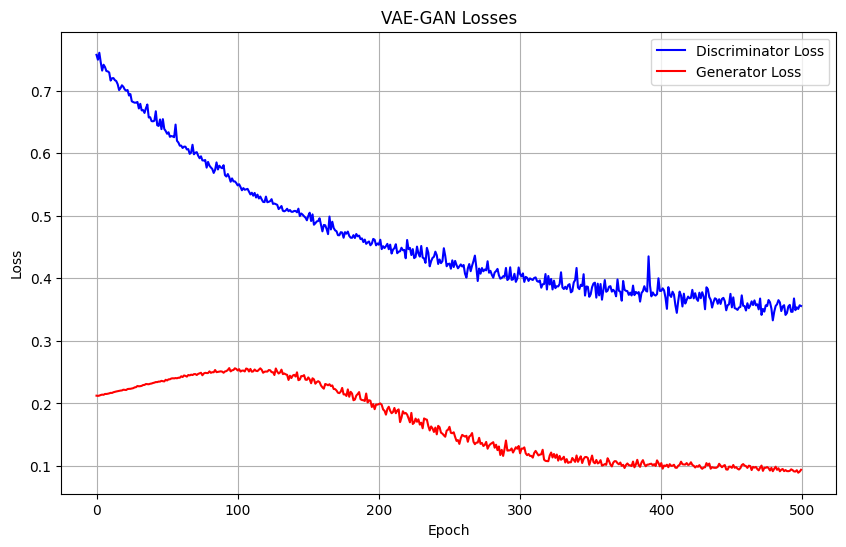

In [35]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(losses['disc'], label='Discriminator Loss', color='blue')
plt.plot(losses['gen'], label='Generator Loss', color='red')
plt.title('VAE-GAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('images/vae-gan_losses.png')
plt.show()

In [36]:
# Generate synthetic data
num_samples = 56000  # specify the number of synthetic samples you want
noise = np.random.normal(0, 1, (num_samples, latent_dim))
sampled_labels = np.random.randint(0, 2, num_samples).reshape(-1, 1)  # Sampled binary labels

# Concatenate noise and sampled_labels before predicting
vaegan_data = generator2.predict([noise, sampled_labels])

# Concatenate the generated data with the corresponding labels
vaegan_data = np.concatenate([vaegan_data, sampled_labels], axis=1)


1750/1750 [==============================] - 2s 1ms/step


In [37]:
# Post-process data
vaegan_num_data = vaegan_data[:,:5]
vaegan_cat_data = vaegan_data[:,5:]
vaegan_data_df = pd.DataFrame()
vaegan_data_df[num_cols] = scaler.inverse_transform(vaegan_num_data)
vaegan_data_df[cat_cols] = vaegan_cat_data
weight = vaegan_data_df['weight']
vaegan_data_df = vaegan_data_df.round().astype(int)
vaegan_data_df['weight'] = weight
vaegan_data_df.head()

,age,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,gender_f,gender_m,cardio
0,20311,167,79.661329,164,176,1,1,0,0,1,1,0,1
1,20082,166,78.780158,169,157,1,1,0,0,1,0,0,0
2,19711,165,75.906268,139,106,1,1,0,0,1,1,0,0
3,20100,167,79.134288,156,141,1,1,0,0,1,1,0,1
4,20287,168,80.161328,176,171,1,1,0,0,1,1,0,1


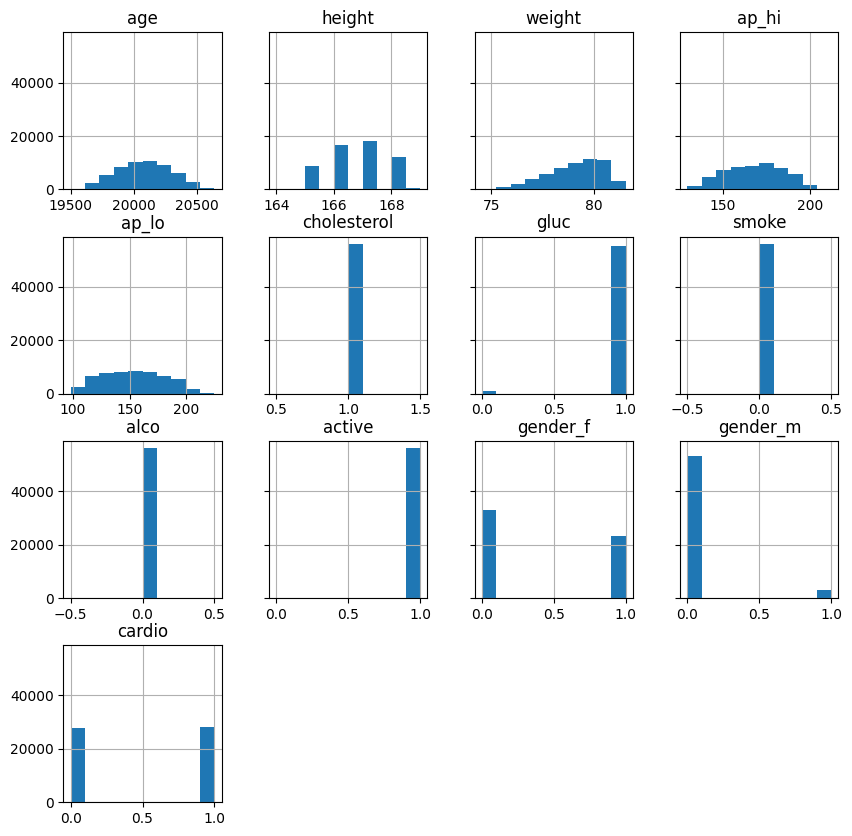

In [38]:
# Plot data summary
vaegan_data_df.hist(figsize=(10,10),sharey=True)
plt.savefig('images/vaegan_data_summary.png');

In [39]:
# Show data summary
vaegan_data_df[num_cols].describe().T[['mean','std','min','max']]

,mean,std,min,max
age,20083.513696,210.718402,19500.00000,20638.000000
height,166.625161,1.016118,164.00000,169.000000
weight,79.080410,1.320923,74.54923,81.525015
ap_hi,167.880375,16.342300,130.00000,212.000000
ap_lo,153.277500,26.931472,98.00000,225.000000


# Classifier

In [40]:
# Seperate features from target
X_test = data_test_normalized[:,:-1]
y_test = data_test_normalized[:,-1]

## Original Data

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data_train_normalized[:,:-1]
y = data_train_normalized[:,-1]

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=12))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


438/438 [==============================] - 1s 2ms/step - loss: 0.5406 - accuracy: 0.7375
Test Accuracy: 73.75%


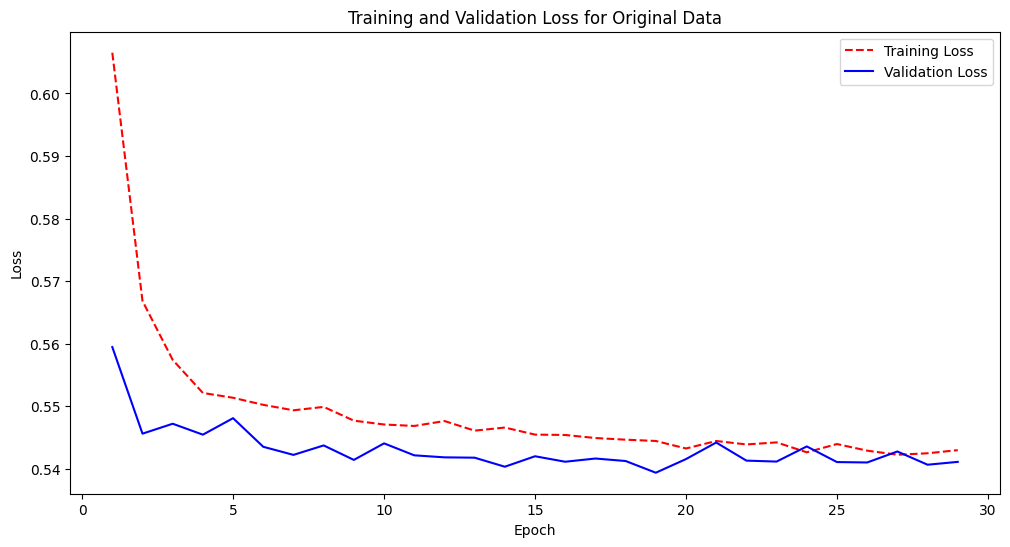

In [42]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(12,6))
plt.plot(epoch_count, training_loss, 'r--', label='Training Loss')
plt.plot(epoch_count, test_loss, 'b-', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Original Data')
plt.savefig('images/original_classifier_loss.png')
plt.show();

## VAE

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = vae_data[:,:-1]
y = vae_data[:,-1]

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=12))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

438/438 [==============================] - 1s 2ms/step - loss: 62.1316 - accuracy: 0.6611
Test Accuracy: 66.11%


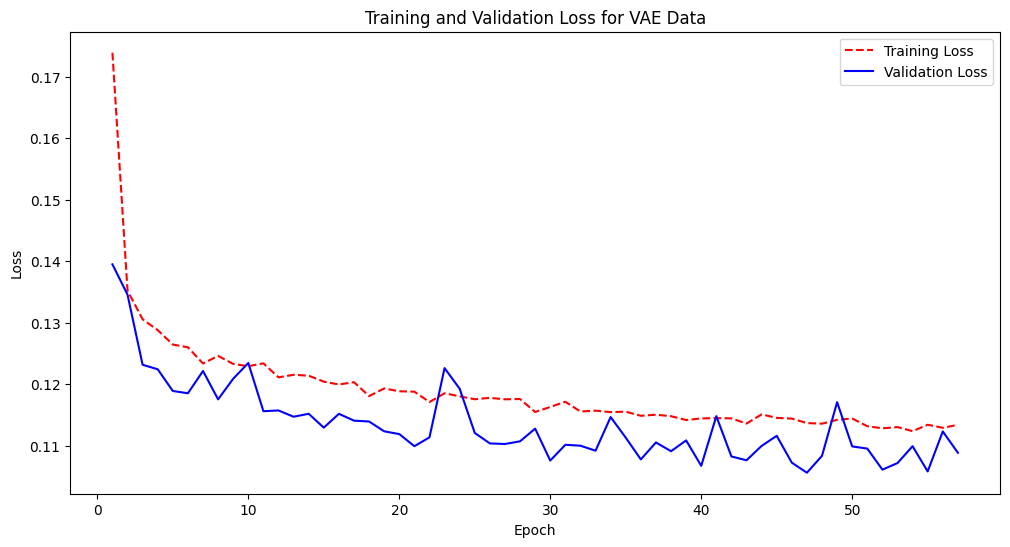

In [44]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(12,6))
plt.plot(epoch_count, training_loss, 'r--', label='Training Loss')
plt.plot(epoch_count, test_loss, 'b-', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VAE Data')
plt.savefig('images/vae_classifier_loss.png')
plt.show();

## GAN

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = gan_data[:,:-1]
y = gan_data[:,-1]

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=12))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


438/438 [==============================] - 1s 1ms/step - loss: 0.8224 - accuracy: 0.4556
Test Accuracy: 45.56%


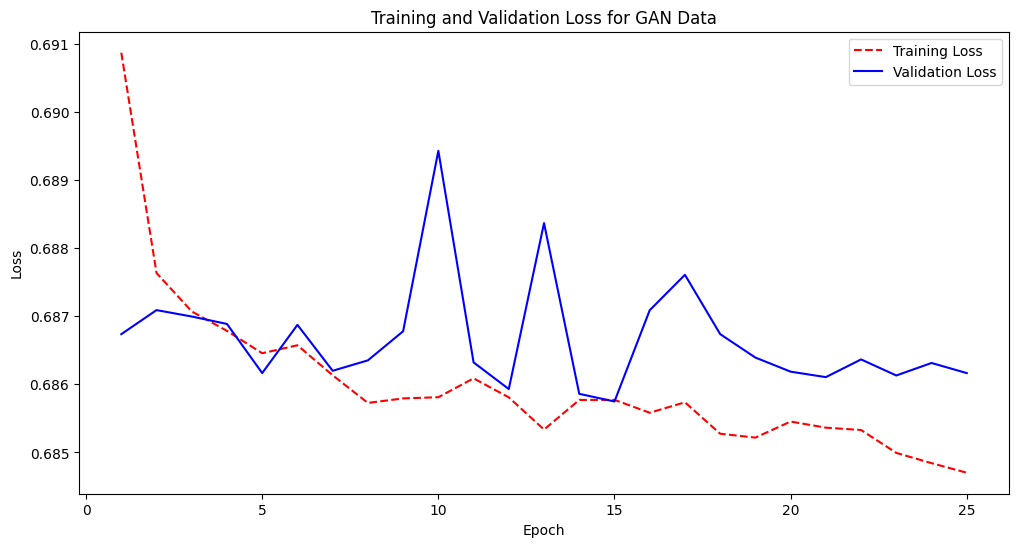

In [46]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(12,6))
plt.plot(epoch_count, training_loss, 'r--', label='Training Loss')
plt.plot(epoch_count, test_loss, 'b-', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for GAN Data')
plt.savefig('images/gan_classifier_loss.png')
plt.show();

## VAE-GAN

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = vaegan_data[:,:-1]
y = vaegan_data[:,-1]

# Define the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=12))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


438/438 [==============================] - 1s 1ms/step - loss: 223.1335 - accuracy: 0.5303
Test Accuracy: 53.03%


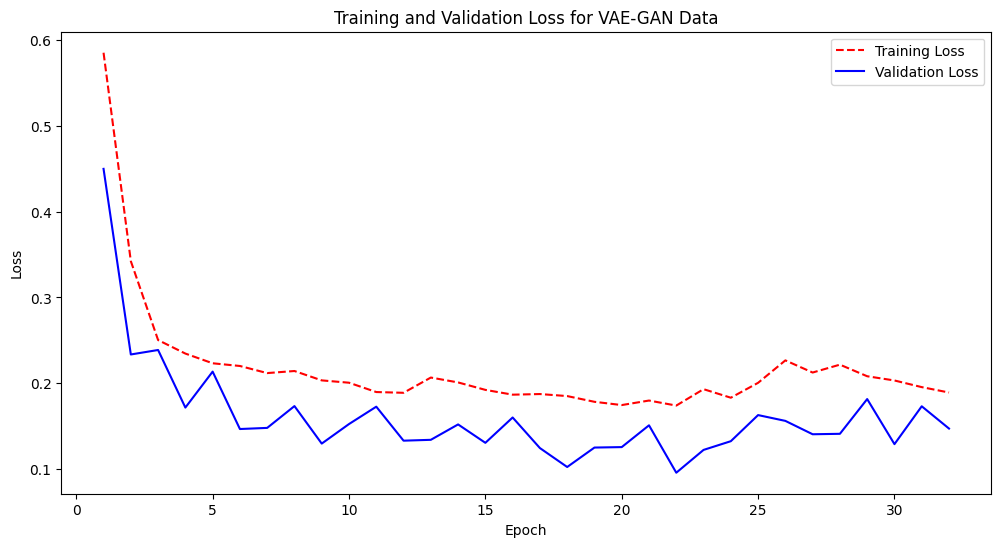

In [48]:
import matplotlib.pyplot as plt

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize=(12,6))
plt.plot(epoch_count, training_loss, 'r--', label='Training Loss')
plt.plot(epoch_count, test_loss, 'b-', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VAE-GAN Data')
plt.savefig('images/vaegan_classifier_loss.png')
plt.show();